In [1]:
### import libraries
import os
import pandas as pd
import numpy as np
import math
import arcpy
from arcpy import env
from arcpy.sa import *
import matplotlib.pyplot as plt

# Check out the ArcGIS Spatial Analyst extension license
arcpy.CheckOutExtension("Spatial")

# Allow ArcGIS to overwrite files with same file name
arcpy.env.overwriteOutput = True

Set workspace directory with the data

In [2]:
### set workspace
direc = r"H:\BORR\Analysis\Multispectral\Composite"

arcpy.env.workspace = direc
print(direc)

H:\BORR\Analysis\Multispectral\Composite


Read in the shapefile of the Study Area 

In [3]:
### read in data

# plots shp file
plots = r"F:\BORR\Analysis\StudyArea_ext.shp"

This section extracts the spatial resolution from each of the flights and sets the resample resolution to the maximum resoltuion

In [4]:
### get pixel_x and pixel_y resolutions as table
### set variable for max resolution

# list rasters in directory
raslist = arcpy.ListRasters("*composite.tif", "TIF")  

# create empty numpy.array
nrow = len(raslist)          # the number of rows wanted in array, equal to # of rasters in list
ncol = 4                     # the number of cols wanted in array
s = (nrow,ncol)              # temp variable setting # of rows and cols
res_table = np.zeros(s)      # create table of '0's
del nrow                     # delete temp variables
del ncol                     # delete temp variables
del s                        # delete temp variables

# set empty row counter variable
rc = 0
for ras in raslist:
    
    #print("loop for raster:", ras)
    
    # update resolution table col #0 w/ flight # from file path
    t = ras.split('F')[1]  # t = temp variable to store flight #
    t = t.split('_')[0]
    res_table[rc,0] = t
    del t                 # clear temporary 't' variable
    
    # update resolution table col #1 w/ flight time
    t = ras.split('_')[1]  # t = temp variable to store time in
    res_table[rc,1] = t
    del t                 # clear temporary 't' variable
    
    # update resolution table col #1 w/ pixel x resolution
    x_result = arcpy.GetRasterProperties_management (ras, "CELLSIZEX")
    x = x_result.getOutput(0)
    res_table[rc,2] = x
    
    # update resolution table col #2 w/ pixel y resolution
    y_result = arcpy.GetRasterProperties_management (ras, "CELLSIZEY")
    y = y_result.getOutput(0)
    res_table[rc,3] = y
    
    # update row counter
    rc = rc + 1
    
# delete temp variables
del rc
del x_result
del x
del y_result
del y

### display raster pixel size (or resolution) table, note that:
  #                          col #0 = flight id from file name
  #                          col #1 = fight time from file name
  #                          col #2 = pixel x resolution
  #                          col #3 = pixel y resolution
print(res_table)

### get max value of each column in resolution table
res_table_max = np.max(res_table, axis=0)
res_table_max = res_table_max[2:4]
res_max = np.max(res_table_max)
print('resample size set to:', res_max)

[[  1.00000000e+00   1.20000000e+03   8.74300000e-02   8.74300000e-02]
 [  2.00000000e+00   1.31500000e+03   7.22300000e-02   7.22300000e-02]
 [  3.00000000e+00   1.41000000e+03   2.25000000e-02   2.25000000e-02]
 [  4.00000000e+00   1.51000000e+03   4.39500000e-02   4.39500000e-02]
 [  5.00000000e+00   8.17000000e+02   4.47200000e-02   4.47200000e-02]
 [  6.00000000e+00   9.32000000e+02   4.42500000e-02   4.42500000e-02]
 [  7.00000000e+00   1.01300000e+03   4.47700000e-02   4.47700000e-02]
 [  8.00000000e+00   1.11000000e+03   4.49700000e-02   4.49700000e-02]
 [  9.00000000e+00   1.21000000e+03   4.47100000e-02   4.47100000e-02]
 [  1.00000000e+01   1.32400000e+03   4.42400000e-02   4.42400000e-02]
 [  1.10000000e+01   1.41000000e+03   4.40100000e-02   4.40100000e-02]
 [  1.20000000e+01   1.51000000e+03   4.36500000e-02   4.36500000e-02]]
resample size set to: 0.08743


This section takes the resolution set above, resamples all the rasters to that resolution using the Nearest resample operator and then clips the resampled raster to the individual treatments within the shapefiles extent

In [5]:
### resample rasters all raster to max pixel size
### clip resampled raster to plots of shapefile extent

for ras in raslist:
    print("loop for raster:", ras)
    
    # resample raster
    res_ras = ras.split('.tif')[0] + '_res.tif'                    # set file name for output file
    arcpy.Resample_management(ras, res_ras, res_max, "NEAREST")    # set resample parameters
    
    # clip to output extent
    msk_ras = res_ras.split('.tif')[0] + '_ext.tif'                # set file name for output files
    out_raster = arcpy.sa.ExtractByMask(res_ras, plots);           # run extract by mask
    out_raster.save(msk_ras)                                       # save clippped file
    
    # clear temp variables
    del res_ras
    del msk_ras
    del out_raster

print ("finished")
# clear temp variables and lists
del ras
del raslist

loop for raster: F01_1200_Multi_120m_composite.tif
loop for raster: F02_1315_Multi_100m_composite.tif
loop for raster: F03_1410_Multi_30m_composite.tif
loop for raster: F04_1510_Multi_60m_composite.tif
loop for raster: F05_0817_Multi_60m_composite.tif
loop for raster: F06_0932_Multi_60m_composite.tif
loop for raster: F07_1013_Multi_60m_composite.tif
loop for raster: F08_1110_Multi_60m_composite.tif
loop for raster: F09_1210_Multi_60m_composite.tif
loop for raster: F10_1324_Multi_60m__composite.tif
loop for raster: F11_1410_Multi_60m_composite.tif
loop for raster: F12_1510_Multi_60m_composite.tif
finished


This section converts the shapefile to raster using the numid field where

In [10]:
# convert plots shp file to raster file for zonal stats calculation
# plots .shp file must have "numid" field that identifies unique plot numeric identifier
plots_ras = "plots_ras.tif"
arcpy.conversion.PolygonToRaster(plots, "numid", plots_ras, "CELL_CENTER", "NONE", res_max)

# create list of resampled and clipped raster files located in directory
raslist = arcpy.ListRasters("*res_ext.tif", "TIF")
print(raslist)

# loop through rasters
for ras in raslist:
    print("loop for raster:", ras)
    
    # set ndvi as band6
    #out_ndvi = ras+'/Band_6'
    #Or recalculate ndvi after resampling
    out_ndvi = (Raster(ras+'/Band_4') - Raster(ras+'/Band_3')) / (Raster(ras+'/Band_4') + Raster(ras+'/Band_3'))

    
    # calc zonal statistics as table
    outdbf = ras.split('.tif')[0] + "_ndvistat.dbf"
    arcpy.sa.ZonalStatisticsAsTable(plots_ras, "Value", out_ndvi, outdbf, "DATA", "ALL")
    
    # delete temp files and clear locks
    del out_ndvi
    del outdbf
    

['F01_1200_Multi_120m_composite_res_ext.tif', 'F02_1315_Multi_100m_composite_res_ext.tif', 'F03_1410_Multi_30m_composite_res_ext.tif', 'F04_1510_Multi_60m_composite_res_ext.tif', 'F05_0817_Multi_60m_composite_res_ext.tif', 'F06_0932_Multi_60m_composite_res_ext.tif', 'F07_1013_Multi_60m_composite_res_ext.tif', 'F08_1110_Multi_60m_composite_res_ext.tif', 'F09_1210_Multi_60m_composite_res_ext.tif', 'F10_1324_Multi_60m__composite_res_ext.tif', 'F11_1410_Multi_60m_composite_res_ext.tif', 'F12_1510_Multi_60m_composite_res_ext.tif']
loop for raster: F01_1200_Multi_120m_composite_res_ext.tif
loop for raster: F02_1315_Multi_100m_composite_res_ext.tif
loop for raster: F03_1410_Multi_30m_composite_res_ext.tif
loop for raster: F04_1510_Multi_60m_composite_res_ext.tif
loop for raster: F05_0817_Multi_60m_composite_res_ext.tif
loop for raster: F06_0932_Multi_60m_composite_res_ext.tif
loop for raster: F07_1013_Multi_60m_composite_res_ext.tif
loop for raster: F08_1110_Multi_60m_composite_res_ext.tif
lo

In [5]:
# get the number of treatments and unique list of treatments
for dbf_file in arcpy.ListFiles("*ndvistat.dbf"):
    # get # of treatments
    nTreatments = arcpy.GetCount_management(dbf_file)
    
    # get unique list of treatments
    field = 'Value'
    values = [row[0] for row in arcpy.da.SearchCursor(dbf_file, field)]
    treatments = set(values)
    
# clear temp variables
del dbf_file
del values
    
# create empty array to update
nrow = len(arcpy.ListFiles("*ndvistat.dbf"))          # the number of rows wanted in array, equal to # of rasters in list
ncol = len(treatments) + 2                            # the number of cols wanted in array, change to 2 if want flight time
s = (nrow,ncol)                                       # temp variable setting # of rows and cols
avg_table = np.zeros(s, dtype=float)                  # create table of '0's
hdr_table = np.zeros(s, dtype=float)                  # create table of '0's
del nrow
del s

# update avg table
# set temp row and col counters to update
rc = 0
cc = 0
# loop through dbf files in directory
for dbf_file in arcpy.ListFiles("*ndvistat.dbf"):
    
    # get flight number from file name and append to table
    t = dbf_file.split('F')[1]
    t = t.split('_')[0]
    avg_table[rc,cc] = t
    hdr_table[rc,cc] = t
    cc = cc + 1
    del t
    
    # get flight time and append to table
    t = dbf_file.split('_')[1]  # t = temp variable to store time in
    avg_table[rc,cc] = t
    hdr_table[rc,cc] = t
    cc = cc + 1
    del t                 # clear temporary 't' variable
    
    fields = ['Value','MEAN']
    with arcpy.da.SearchCursor(dbf_file, fields) as cursor:
        for row in cursor:
            h=row[0]
            v=row[1]
            avg_table[rc,cc] = v
            hdr_table[rc,cc] = h
            cc = cc + 1
            del h
            del v     
            
    rc = rc + 1
    cc = 0

print(avg_table)
print(hdr_table)

[[  1.00000000e+00   1.20000000e+03   2.70626982e-01   2.22934833e-01
    2.06403409e-01   2.11635353e-01   2.25074994e-01   2.69386192e-01
    2.33849286e-01   3.73392729e-01   3.67297801e-01   3.32850921e-01
    5.03047271e-01   4.00419399e-01   4.38848571e-01   4.86998589e-01
    4.99583057e-01   4.93633178e-01   4.45700101e-01]
 [  2.00000000e+00   1.31500000e+03   2.54775854e-01   2.15206250e-01
    2.06617664e-01   2.02304099e-01   2.26962976e-01   2.61773284e-01
    2.25689030e-01   3.59662619e-01   3.54405679e-01   3.10646686e-01
    4.73601746e-01   4.27101911e-01   4.20613172e-01   4.91978617e-01
    4.75101022e-01   4.76786530e-01   4.36978549e-01]
 [  3.00000000e+00   1.41000000e+03   2.60547165e-01   2.20933565e-01
    1.91228287e-01   1.86162065e-01   1.79390512e-01   1.74038216e-01
    2.18400627e-01   2.54177720e-01   1.77409588e-01   2.73705509e-01
    3.29302148e-01   2.92969452e-01   3.43198193e-01   2.77992626e-01
    4.67003586e-01   4.76685605e-01   4.15541522e-01

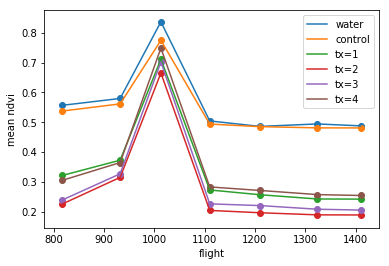

In [14]:
start=4 # this leaves out the first 4 day 1 flights
end=11
plt.plot(avg_table[start:end,1], avg_table[start:end,15])
plt.scatter(avg_table[4:11,1], avg_table[4:11,15])
plt.plot(avg_table[4:11,1], avg_table[4:11,17])
plt.scatter(avg_table[4:11,1], avg_table[4:11,17])
plt.plot(avg_table[4:11,1], avg_table[4:11,2])
plt.scatter(avg_table[4:11,1], avg_table[4:11,2])
plt.plot(avg_table[4:11,1], avg_table[4:11,5])
plt.scatter(avg_table[4:11,1], avg_table[4:11,5])
plt.plot(avg_table[4:11,1], avg_table[4:11,8])
plt.scatter(avg_table[4:11,1], avg_table[4:11,8])
plt.plot(avg_table[4:11,1], avg_table[4:11,11])
plt.scatter(avg_table[4:11,1], avg_table[4:11,11])




plt.xlabel('flight')
plt.ylabel('mean ndvi')
plt.legend(('water','control', 'tx=1','tx=2','tx=3', 'tx=4'),
           loc='upper right')

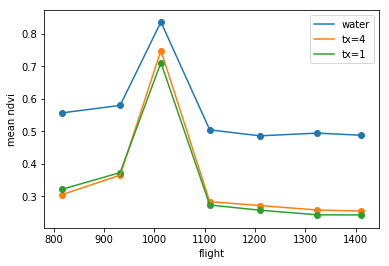

In [15]:
start=4 # this leaves out the first 4 day 1 flights
end=11

plt.plot(avg_table[start:end,1], avg_table[start:end,15])
plt.scatter(avg_table[start:end,1], avg_table[start:end,15])
plt.plot(avg_table[start:end,1], avg_table[start:end,11])
plt.scatter(avg_table[start:end,1], avg_table[start:end,11])
plt.plot(avg_table[start:end,1], avg_table[start:end,2])
plt.scatter(avg_table[start:end,1], avg_table[start:end,2])
plt.xlabel('flight')
plt.ylabel('mean ndvi')
plt.legend(('water', 'tx=4', 'tx=1'),
           loc='upper right')